In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from matplotlib import pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [5]:
train_df=pd.read_csv("../input/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
print(train_df[train_df["Id"]=="w_f48451c"])
print(train_df[train_df["Id"]=="w_c3d896a"])


               Image         Id
0      0000e88ab.jpg  w_f48451c
1111   0af805558.jpg  w_f48451c
2746   1c351b88e.jpg  w_f48451c
10983  6f7abb1be.jpg  w_f48451c
11786  77a44bf94.jpg  w_f48451c
12019  79c77838d.jpg  w_f48451c
14338  9064d5875.jpg  w_f48451c
15862  9fc84d2ae.jpg  w_f48451c
19245  c1ec12eb6.jpg  w_f48451c
19675  c64e5e861.jpg  w_f48451c
20052  c9df69a69.jpg  w_f48451c
21784  db0699767.jpg  w_f48451c
22547  e2f1b6c4a.jpg  w_f48451c
22642  e3f2dbd25.jpg  w_f48451c
               Image         Id
1      0001f9222.jpg  w_c3d896a
2864   1d6ccd05a.jpg  w_c3d896a
4362   2cccac55a.jpg  w_c3d896a
20142  cad8eabe4.jpg  w_c3d896a


In [45]:
image1="../input/train/0000e88ab.jpg" #whale w_f48451c
image2="../input/train/e2f1b6c4a.jpg" #whale w_f48451c

image3="../input/train/cad8eabe4.jpg" #whale w_f48451c

In [46]:

print("DONE")

DONE


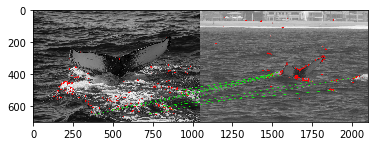

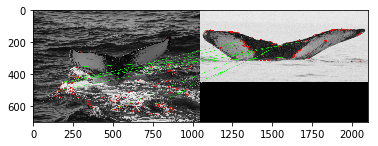

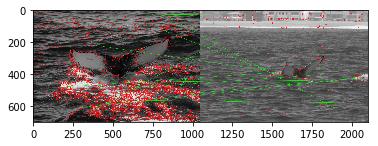

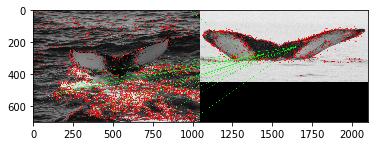

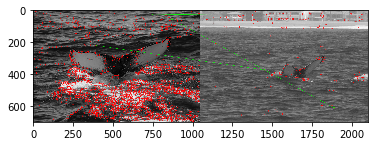

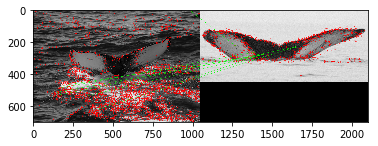

Not enough matches are found - 3/10


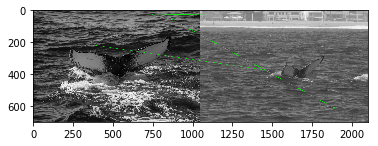

Not enough matches are found - 8/10


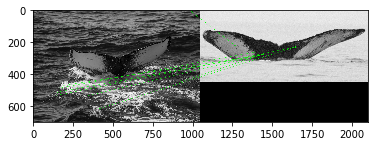

In [50]:
def match_and_show(im1,im2):
    img1 = cv2.imread(im1,0)          # queryImage
    img2 = cv2.imread(im2,0) # trainImage

# Initiate SIFT detector
    orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
    matches = bf.match(des1,des2)

# Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),                   
                   flags = 0)

# Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], None,**draw_params)
    
    plt.imshow(img3),plt.show()
    return None
def match_b_force(im1,im2):
    img1 = cv2.imread(im1,0)          # queryImage
    img2 = cv2.imread(im2,0) # trainImage

    # Initiate SIFT detector
    sift = cv2.KAZE_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),                   
                   flags = 0)
    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,**draw_params)

    plt.imshow(img3),plt.show()
    return None

def flann_mach(im1,im2):
    
    img1 = cv2.imread(im1,0)          # queryImage
    img2 = cv2.imread(im2,0) # trainImage

    # Initiate SIFT detector
    sift = cv2.KAZE_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

    plt.imshow(img3,),plt.show()
    return None
 
def mach_w_ratio(im1,im2):
    MIN_MATCH_COUNT = 10

    img1 = cv2.imread(im1,0)          # queryImage
    img2 = cv2.imread(im2,0) # trainImage

    # Initiate SIFT detector
    sift = cv2.KAZE_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

    plt.imshow(img3, 'gray'),plt.show()        
    return None
match_and_show(image1,image2)
match_and_show(image1,image3)

match_b_force(image1,image2)
match_b_force(image1,image3)

flann_mach(image1,image2)
flann_mach(image1,image3)

mach_w_ratio(image1,image2)
mach_w_ratio(image1,image3)